In [1]:
import lale.datasets.openml
import lale.helpers
import pandas as pd
(orig_train_X, train_y), (test_X, test_y) = \
    lale.datasets.openml.fetch('credit-g', 'classification', preprocess=False)
train_X = lale.helpers.add_missing_values(orig_train_X, seed=42)
train_X.tail(6)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
763,no checking,21.0,critical/other existing credit,new car,NaN,no known savings,>=7,4.0,male single,none,4.0,no known property,30.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
835,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,none,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,none,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,none,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,none,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,none,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


In [2]:
from lale.lib.lale import AutoPipeline
trainable = AutoPipeline(prediction_type='classification', max_evals=10)
trained = trainable.fit(train_X, train_y)

100%|█████████| 9/9 [01:23<00:00,  9.23s/trial, best loss: -0.7298228157458323]


In [3]:
from sklearn.metrics import accuracy_score
predicted = trained.predict(test_X)
print(f'accuracy {accuracy_score(predicted, test_y):.1%}')

accuracy 73.9%


In [4]:
trained.summary()

,log_loss,loss,status,tid,time
name,,,,,
baseline,NaN,-0.6845238095238095,ok,NaN,0.104959
p0,0.558005,-0.695527,ok,0.0,1.304129
p1,0.609906,-0.695527,ok,1.0,1.230496
p2,0.620095,-0.685101,ok,2.0,1.245572
p3,11.651652,-0.493451,ok,3.0,1.229659
p4,0.614610,-0.695527,ok,4.0,1.262807
p5,0.614623,-0.695527,ok,5.0,1.280324
p6,0.727516,-0.304473,ok,6.0,1.753739
p7,0.632435,-0.689556,ok,7.0,1.356967


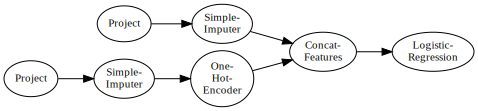

In [5]:
trained.get_pipeline().visualize()

In [6]:
trained.get_pipeline().pretty_print(ipython_display=True)

```python
from lale.lib.lale import Project
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from lale.lib.lale import ConcatFeatures
from sklearn.linear_model import LogisticRegression
import lale

lale.wrap_imported_operators()
project_0 = Project(
    columns={"type": "number"},
    drop_columns=lale.lib.lale.categorical(max_values=5),
)
project_1 = Project(columns=lale.lib.lale.categorical(max_values=5))
simple_imputer_1 = SimpleImputer(strategy="most_frequent")
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
logistic_regression = LogisticRegression(
    C=10618.818622619909,
    multi_class="auto",
    solver="newton-cg",
    tol=0.09200172255146725,
)
pipeline = (
    (
        (project_0 >> SimpleImputer())
        & (project_1 >> simple_imputer_1 >> one_hot_encoder)
    )
    >> ConcatFeatures()
    >> logistic_regression
)
```